In [43]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import log_reg_tensorflow as lrf
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("mnist_dataset/train.csv")

In [3]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X = df[['pixel{}'.format(i) for i in range(784)]].values.astype(np.float32)
mu = X.mean(axis=0)
std = X.std(axis=0)
np.place(std, std == 0, 1)
X_train, X_test, y_train, y_test = train_test_split((X-mu)/std, 
                                                    df['label'].values.astype(np.int32), test_size=0.2, random_state=42)

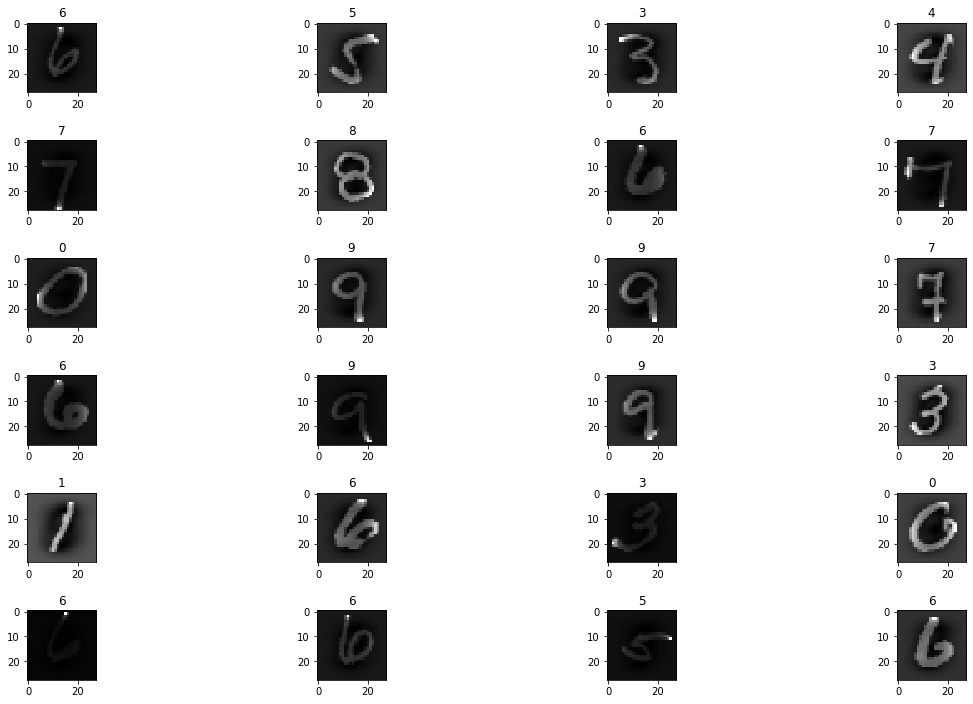

In [76]:
imageside = 28
cols = 4
rows = 6
f, axarr = plt.subplots(rows,cols,figsize=(18,10))
for i in range(rows):
    for j in range(cols):
        axarr[i,j].imshow(X_train[cols*i+j].reshape(imageside,imageside), cmap='gray')
        axarr[i,j].set_title(y_train[cols*i+j])

f.tight_layout(pad=1.5)

In [74]:
tf.reset_default_graph() #important otherwise get errors - boilerplate
logreg = lrf.MulticlassLogisticRegression(num_epochs=1000,
                                          print_epoch=100,
                                          learning_rate=2e-3,
                                          gd_type='full', #gradient descent type
                                          mu = 0.9, #momentum parameter mu
                                          decay = 0.99 #decay rate of RMSProp
                                         )
logreg.fit(X_train, y_train)

epoch:  0 cost:  31745.582 accuracy:  0.6985119047619047
epoch:  100 cost:  6363.4204 accuracy:  0.9475297619047619
epoch:  200 cost:  5796.13 accuracy:  0.9519642857142857
epoch:  300 cost:  5503.3457 accuracy:  0.9550297619047619
epoch:  400 cost:  5299.399 accuracy:  0.9566369047619048
epoch:  500 cost:  5149.0483 accuracy:  0.9582440476190476
epoch:  600 cost:  5049.3306 accuracy:  0.9591369047619047
epoch:  700 cost:  4968.701 accuracy:  0.9594642857142858
epoch:  800 cost:  4918.4917 accuracy:  0.9595833333333333
epoch:  900 cost:  4897.9243 accuracy:  0.9597321428571428


In [75]:
print("Model accuracy on training set: {}\n".format(round(logreg.score(y_train, logreg.predict(X_train)),4))+
      "Model accuracy on test set: {}".format(logreg.score(y_test, logreg.predict(X_test))))

INFO:tensorflow:Restoring parameters from ./logreg_model-1000
INFO:tensorflow:Restoring parameters from ./logreg_model-1000
Model accuracy on training set: 0.9597
Model accuracy on test set: 0.8972619047619048
